In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bz2
import re
import tensorflow  as tf
from keras import models, layers, optimizers, Model
from keras.utils.vis_utils import plot_model
from keras_preprocessing.text import Tokenizer, text_to_word_sequence
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences 
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.models import Sequential, Model
from keras.layers import Input,Dense,LSTM,SpatialDropout1D,Embedding, Conv1D, BatchNormalization, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, MaxPool1D, GlobalMaxPool1D, TextVectorization, Attention, Activation, RepeatVector, Permute, Multiply, Lambda
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import pickle
import pydot
import graphviz
import pydotplus


The codeblock directly below is only to be executed if train_data.txt and/or test_data.txt is mssing

In [3]:
###Extracting the data from bz2 files to txt files


path= 'train.ft.txt'
with bz2.open('tip\\train.ft.txt.bz2', 'rt', encoding = 'utf-8') as compressed_files, open (path, 'w', encoding= 'utf-8') as fil:
    for line in compressed_files:
        fil.write(line)
    print("Train extracted")

path1= 'test.ft.txt'
with bz2.open('tip\\test.ft.txt.bz2', 'rt', encoding = 'utf-8') as compressed_files, open (path1, 'w', encoding= 'utf-8') as fil:
    for line in compressed_files:
        fil.write(line)
    print("test extracted")

Train extracted
test extracted


In [7]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    with open(file, 'r', encoding='utf-8') as f:
        lines = tqdm(f.readlines(), desc=f"Reading {file}")
        for line in lines:
            labels.append(int(line[9]) - 1)
            texts.append(line[10:].strip())
    return np.array(labels), texts

# Train data
train_label, train_text = get_labels_and_texts("train_data.txt")
# Test data
test_label, test_text = get_labels_and_texts("test_data.txt")


Reading test_data.txt: 100%|██████████| 400000/400000 [00:00<00:00, 742773.08it/s]


Preproccessing part

In [8]:
def preprocess_text(text):
    # Remove all non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    return text

In [9]:
# Preprocess train_texts
low_train_text = [preprocess_text(text) for text in train_text]
# Preprocess test_texts
low_test_text = [preprocess_text(text) for text in test_text]

In [10]:
##Ensuring that the amount of labels are the same as the amount of text revies
print("Train size", len(low_train_text))
print("Train label size", len(train_label))
print ("Test size", len(low_test_text))
print("test size length", len(test_label))

Train size 3600000
Train label size 3600000
Test size 400000
test size length 400000


In [11]:
low_test_text[0]

'great cd my lovely pat has one of the great voices of her generation i have listened to this cd for years and i still love it when im in a good mood it makes me feel better a bad mood just evaporates like sugar in the rain this cd just oozes life vocals are jusat stuunning and lyrics just kill one of lifes hidden gems this is a desert isle cd in my book why she never made it big is just beyond me everytime i play this no matter black white young old male female everybody says one thing who was that singing '

In [12]:
test_text[0]

'Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"'

In [13]:
train_text[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [14]:
low_train_text[0]

'stuning even for the nongamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen '

Visualizing studio code aka (VS code)

c:\Users\Walid\anaconda3\envs\Zetsu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Walid\anaconda3\envs\Zetsu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Walid\anaconda3\envs\Zetsu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


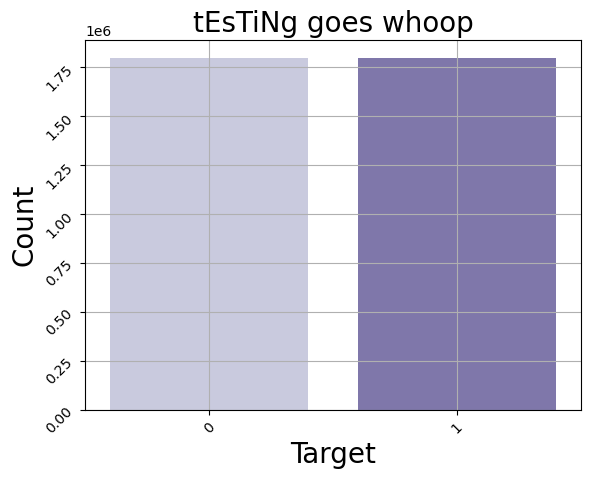

In [15]:
pd.DataFrame(train_label).value_counts()
sns.countplot(x=pd.DataFrame(train_label)[0],palette='Purples')
plt.title('tEsTiNg goes whoop',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.savefig('figures/testing.png')
plt.show()


c:\Users\Walid\anaconda3\envs\Zetsu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Walid\anaconda3\envs\Zetsu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Walid\anaconda3\envs\Zetsu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


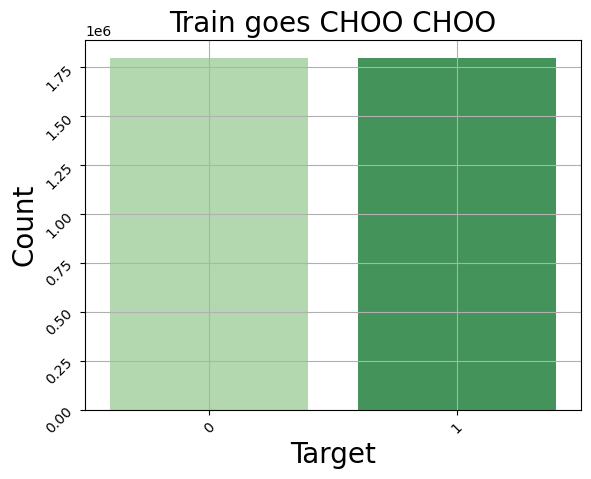

In [16]:
pd.DataFrame(test_label).value_counts()
sns.countplot(x=pd.DataFrame(train_label)[0],palette='Greens')
plt.title('Train goes CHOO CHOO',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.savefig('figures/train goes choo choo.png')
plt.show()

New dataframes whoopå whoop


In [17]:
low_train_text_df=pd.DataFrame(low_train_text)
low_test_text_df= pd.DataFrame(low_test_text)



In [18]:
low_train_text_df.head()

,0
0,stuning even for the nongamer this sound track...
1,the best soundtrack ever to anything im readin...
2,amazing this soundtrack is my favorite music o...
3,excellent soundtrack i truly like this soundtr...
4,remember pull your jaw off the floor after hea...


In [19]:
low_test_text_df.head()

,0
0,great cd my lovely pat has one of the great vo...
1,one of the best game music soundtracks for a g...
2,batteries died within a year i bought this cha...
3,works fine but maha energy is better check out...
4,great for the nonaudiophile reviewed quite a b...


Wordcloudin


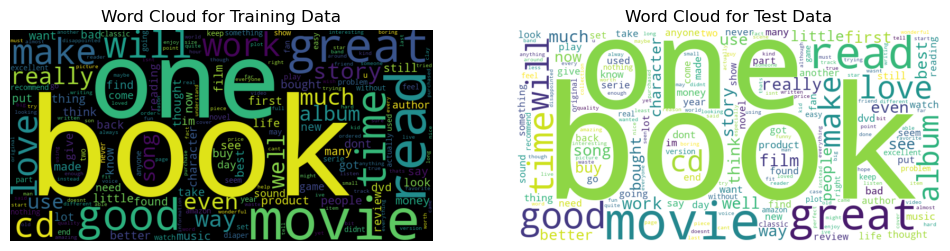

In [20]:
# Combine the first 20,000 preprocessed texts into a single string for training data
all_train_texts = ' '.join(low_train_text[:20000])

# Combine the first 20,000 preprocessed texts into a single string for test data
all_test_texts = ' '.join(low_test_text[:20000])

# Generate word cloud for training data
wordcloud_train = WordCloud(width=800, height=400, background_color='black').generate(all_train_texts)

# Generate word cloud for test data
wordcloud_test = WordCloud(width=800, height=400, background_color='white').generate(all_test_texts)

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.title('Word Cloud for Training Data')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_test, interpolation='bilinear')
plt.title('Word Cloud for Test Data')
plt.axis('off')
plt.savefig('figures/wordcloud.jpg')

plt.show()

Tokenization fuckaround

In [21]:
# Define the maximum number of words and maximum length of sequences
max_features = 12000
max_length = 100

tokenizer = Tokenizer(num_words=max_features)

# Fit the tokenizer on training texts
tokenizer.fit_on_texts(low_train_text)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(low_train_text)
test_sequences = tokenizer.texts_to_sequences(low_test_text)

# Pad sequences to ensure uniform length
train_sequences = pad_sequences(train_sequences, maxlen=max_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)


In [22]:
print("Shape of train_sequences:", train_sequences.shape)
print("Shape of train_label:", train_label.shape) # Due to some errors these are written around to check, incase there is a bug around

Shape of train_sequences: (3600000, 100)
Shape of train_label: (3600000,)


CNN MOdel (insert a pun or a joke about cnn later)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 64)           768000    
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            12352     
                                                                 
 batch_normalization (BatchN  (None, 98, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 64)            20544 

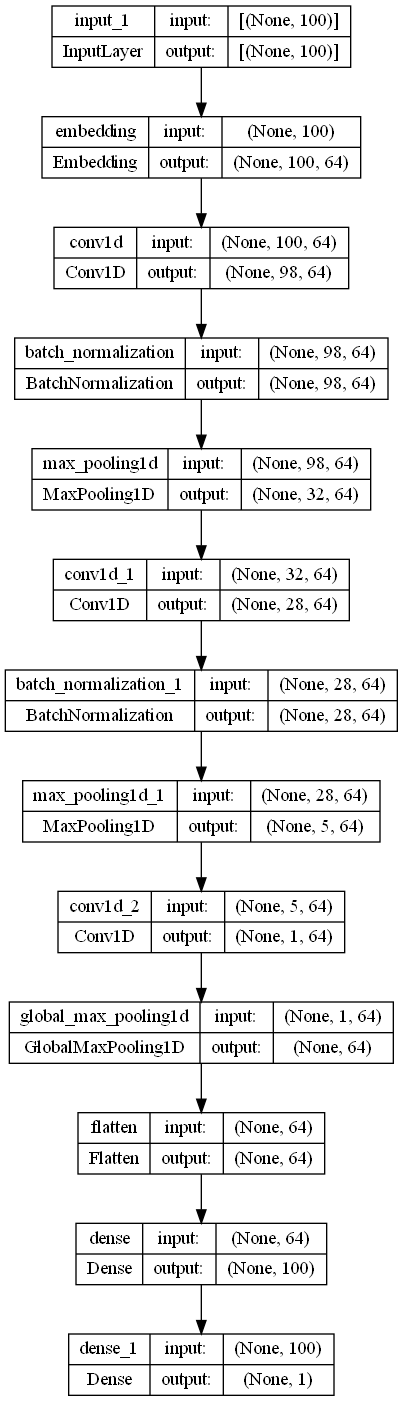

In [23]:

def CNN_Model():   
    sequences = Input(shape=(max_length,))
    embedded = Embedding(max_features, 64)(sequences)
    
    # creating the layers sequentially
    a = (Conv1D(64, 3, activation='relu')(embedded))
    a = (BatchNormalization())(a)
    a = (MaxPooling1D(3))(a)

    a = (Conv1D(64, 5, activation='relu'))(a)
    a = (BatchNormalization())(a)
    a = (MaxPooling1D(5))(a)
    
    a = (Conv1D(64, 5, activation='relu'))(a)
    a = (GlobalMaxPooling1D())(a)
    a = (Flatten())(a)
    a = (Dense(100, activation='relu'))(a)
    predictions = Dense(1, activation='sigmoid')(a)
    
    # model with input and output
    model = Model(inputs=sequences, outputs=predictions)
    # ------
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']  
    )
    model.summary()
    return model

cnn_model = CNN_Model()
plot_model(cnn_model, to_file='figures/CNN_model.png', show_shapes=True, show_layer_names=True)

In [24]:

# Fit the model to the training data
cnn_history = cnn_model.fit(train_sequences, train_label,
                        epochs=5,
                        batch_size=128,
                        validation_split=0.2)  # 

Epoch 1/5
22500/22500 [==============================] - 159s 7ms/step - loss: 0.2186 - accuracy: 0.9117 - val_loss: 0.1922 - val_accuracy: 0.9239
Epoch 2/5
22500/22500 [==============================] - 151s 7ms/step - loss: 0.1817 - accuracy: 0.9289 - val_loss: 0.1841 - val_accuracy: 0.9280
Epoch 3/5
22500/22500 [==============================] - 145s 6ms/step - loss: 0.1652 - accuracy: 0.9366 - val_loss: 0.1898 - val_accuracy: 0.9248
Epoch 4/5
22500/22500 [==============================] - 132s 6ms/step - loss: 0.1520 - accuracy: 0.9424 - val_loss: 0.1961 - val_accuracy: 0.9230
Epoch 5/5
22500/22500 [==============================] - 149s 7ms/step - loss: 0.1406 - accuracy: 0.9474 - val_loss: 0.1940 - val_accuracy: 0.9263


In [25]:
pd.DataFrame(cnn_history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.218576,0.911671,0.192155,0.923858
1,0.181742,0.928931,0.184116,0.928050
2,0.165221,0.936579,0.189793,0.924808
3,0.151970,0.942394,0.196112,0.922989
4,0.140626,0.947350,0.193990,0.926256


In [26]:
# Save the CNN history 
with open('cnn_history.pkl', 'wb') as f:
    pickle.dump(cnn_history.history, f)

In [27]:
# should only be executed if there is a cnn_history.pkl in the folder, this is only to reduce the overall time of the code for training the cnn_model
#with open('cnn_history.pkl', 'rb') as f:
 #   loaded_cnn_history = pickle.load(f) ## this loads a dictionary
  #  cnn_history_df = pd.DataFrame(loaded_cnn_history) # is only used if the user restarts the code then this shall be used

In [28]:
print("Shape of train_sequences:", train_sequences.shape)
print("Shape of train_label:", train_label.shape) # Due to some errors these are written around to check, incase there is a bug around

Shape of train_sequences: (3600000, 100)
Shape of train_label: (3600000,)


In [29]:
print(cnn_history_df) # only if the code is restarted and the cnn_history codeblock has not been executed

       loss  accuracy  val_loss  val_accuracy
0  0.218576  0.911671  0.192155      0.923858
1  0.181742  0.928931  0.184116      0.928050
2  0.165221  0.936579  0.189793      0.924808
3  0.151970  0.942394  0.196112      0.922989
4  0.140626  0.947350  0.193990      0.926256


12500/12500 [==============================] - 18s 1ms/step


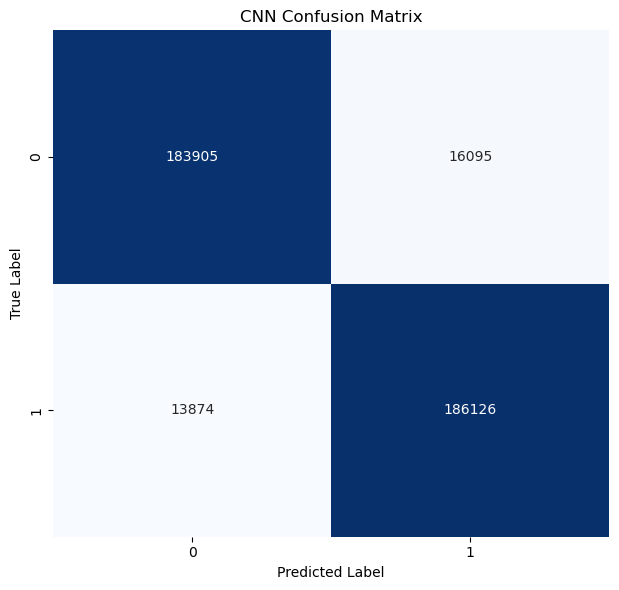

In [30]:

# CNN model predictions
cnn_predictions = cnn_model.predict(test_sequences)
cnn_predicted_labels = (cnn_predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# Creating hte  confusion matrices
cnn_conf_matrix = confusion_matrix(test_label, cnn_predicted_labels)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.savefig('figures/cnn_confusion_matrix.png')
plt.show()


In [31]:
#Calculates the classifcation report for the CNN model
cnn_classification_report = classification_report(test_label, cnn_predicted_labels)

print("CNN Classification report:")
print(cnn_classification_report)

CNN Classification report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92    200000
           1       0.92      0.93      0.93    200000

    accuracy                           0.93    400000
   macro avg       0.93      0.93      0.93    400000
weighted avg       0.93      0.93      0.93    400000



RNN Model (need to create A RNN joke). to be hahahahaah

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 72)      864000      ['input_3[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 100, 32)      13440       ['embedding_2[0][0]']            
                                                                                                  
 dense_3 (Dense)                (None, 100, 1)       33          ['lstm_1[0][0]']                 
                                                                                            

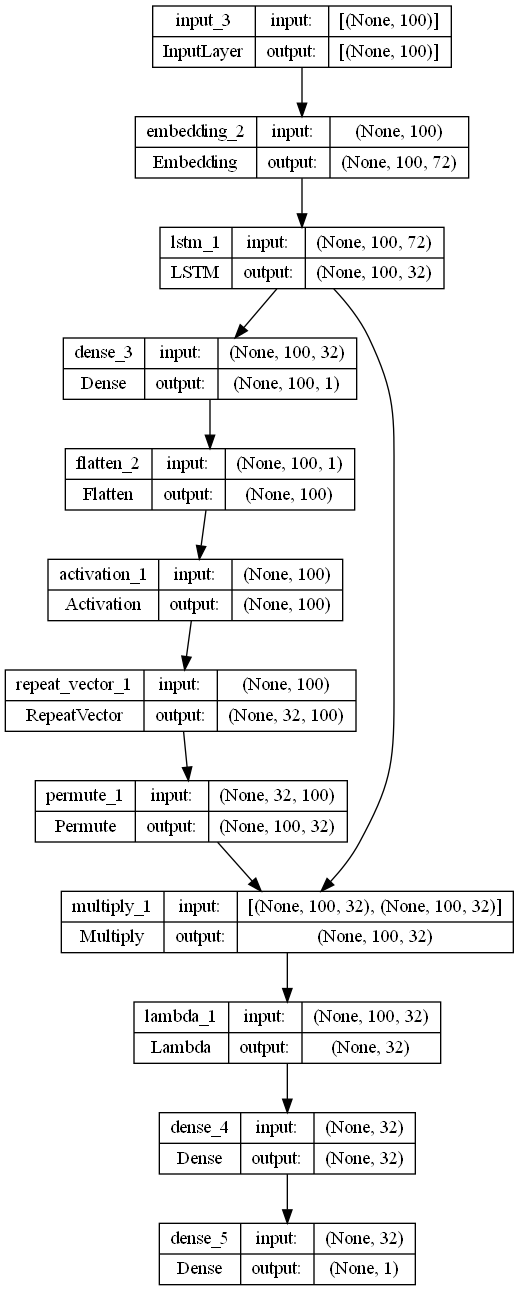

In [35]:

def RNN_Model(max_length, max_features):
    # Creating the model
    sequence_inputs = Input(shape=(max_length,))

    # Embedding layer
    embedded = Embedding(input_dim=max_features, output_dim=72, input_length=max_length)(sequence_inputs) #output dim is reduced to decrease the training time

    # LSTM layer with 32 units and dropout
    lstm_out = LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedded)

    # Attention layer

    # Attention mechanism
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(32)(attention)
    attention = Permute([2,1])(attention)

    # Weighted sum of LSTM output with attention
    weighted_sum = Multiply()([lstm_out, attention])
    representation = Lambda(lambda x: K.sum(x, axis=1))(weighted_sum)

    # connected layer
    dense_out = Dense(32, activation='relu')(representation)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(dense_out)

    # Define the model
    model = Model(inputs=sequence_inputs, outputs=output)


    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()
    
    return model


# Creating the  RNN model
rnn_model = RNN_Model(max_length, max_features)

# Plot the model architecture
plot_model(rnn_model, to_file='figures/RNN_model.png', show_shapes=True, show_layer_names=True)


In [36]:
# Fitting the model with the training data
rnn_history = rnn_model.fit(train_sequences, train_label,
                            epochs=3, 
                            batch_size=128, 
                            validation_split=0.2) # Due to time consumptino, i will limit it to 3 epochs at most, as setting epochs = 4. becomes time conssuming and ensures blue screen of death

Epoch 1/3
22500/22500 [==============================] - 6147s 273ms/step - loss: 0.1905 - accuracy: 0.9245 - val_loss: 0.1640 - val_accuracy: 0.9370
Epoch 2/3
22500/22500 [==============================] - 7470s 332ms/step - loss: 0.1568 - accuracy: 0.9402 - val_loss: 0.1519 - val_accuracy: 0.9428
Epoch 3/3
22500/22500 [==============================] - 7058s 314ms/step - loss: 0.1465 - accuracy: 0.9447 - val_loss: 0.1499 - val_accuracy: 0.9439


In [37]:

# Predict the attention weights for the first review in the test set
first_review_text = test_text[0]
attention_weights = rnn_model.predict(test_sequences[0].reshape(1, -1))
print("Attention weights for the first review:", attention_weights)

1/1 [==============================] - 0s 336ms/step
Attention weights for the first review: [[0.9931317]]


In [38]:
pd.DataFrame(rnn_history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.190543,0.924545,0.163957,0.936994
1,0.156799,0.940166,0.151900,0.942774
2,0.146479,0.944650,0.149921,0.943896


In [39]:
#with open('rnn_history.pkl', 'wb') as f:
#   pickle.dump(rnn_history.history, f)


In [40]:
#IGNORE
# should only be executed if there is a cnn_history.pkl in the folder, this is only to reduce the overall time of the code for training the cnn_model
#with open('rnn_history.pkl', 'rb') as f:
#   loaded_rnn_history = pickle.load(f)
#  rnn_history_df = pd.DataFrame(loaded_rnn_history)

12500/12500 [==============================] - 663s 53ms/step


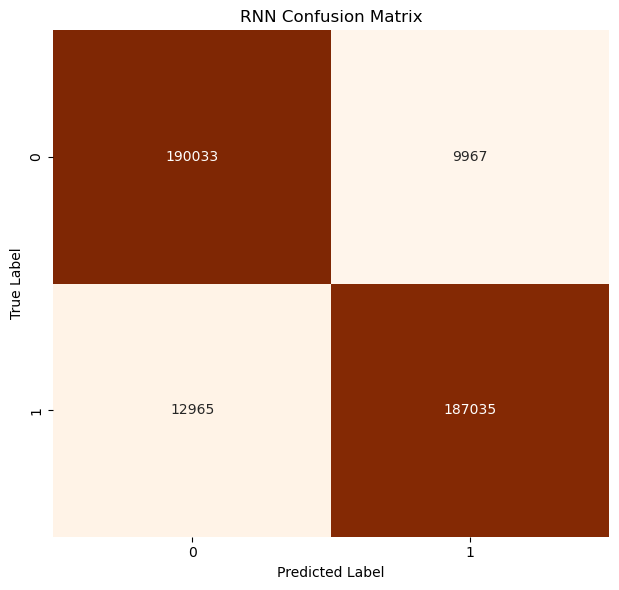

In [41]:

# RNN model predictions
rnn_predictions = rnn_model.predict(test_sequences)
rnn_predicted_labels = (rnn_predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# Creatin confusion matrices
rnn_conf_matrix = confusion_matrix(test_label, rnn_predicted_labels)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.heatmap(rnn_conf_matrix, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('RNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.savefig('figures/RNN_Confusion_Matrix.png')
plt.show()


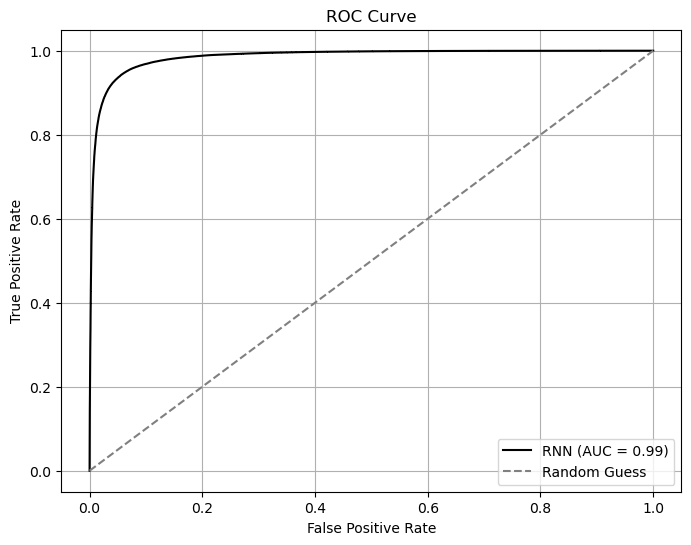

In [42]:

# Compute ROC curve and AUC for RNN
rnn_fpr, rnn_tpr, rnn_thresholds = roc_curve(test_label, rnn_predictions)
rnn_auc = auc(rnn_fpr, rnn_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(rnn_fpr, rnn_tpr, label=f'RNN (AUC = {rnn_auc:.2f})', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig('figures/RNN_ROC_Curve.png')
plt.show()

In [43]:

# Creating the  classification report for RNN model
rnn_classification_report = classification_report(test_label, rnn_predicted_labels)

print("RNN Classification Report: ")
print(rnn_classification_report)

RNN Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.95      0.94    200000
           1       0.95      0.94      0.94    200000

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000



Review check with rnn/ Higly usable but hard to explain

In [44]:
def get_attention_weights_for_review(review_text):
    # Split the review text into words
    words = review_text.split()

    # Generate random attention weights for each word
    attention_weights = np.random.rand(len(words))

    return attention_weights

# Example usage

[3.37736796e-06 9.74040236e-03 1.97251926e-03 1.63972386e-02
 4.88961064e-03 3.83827543e-03 3.66546549e-04 1.53266882e-02
 1.49979044e-02 1.34197752e-02 9.38157651e-03 1.71991242e-02
 3.03055143e-03 1.42557968e-02 5.56435395e-03 8.99789378e-03
 1.02971880e-02 9.52130787e-03 1.67491572e-02 9.63703205e-03
 1.21298887e-02 8.74330804e-03 1.54689149e-02 1.59562354e-02
 1.46160032e-03 1.68782925e-02 1.48698386e-02 8.13190030e-03
 1.27350612e-02 1.72471747e-02 1.01976778e-02 8.83673088e-03
 1.02287394e-02 8.01636276e-03 5.65059587e-03 1.18985997e-02
 1.82206749e-03 6.32676344e-03 9.63677951e-03 1.51115459e-02
 1.22913525e-02 1.13077238e-02 1.19900354e-02 1.54175434e-02
 1.54678962e-02 1.22999739e-02 9.16448966e-03 9.13097498e-03
 1.47508088e-02 4.24440817e-03 9.63882850e-03 1.13537724e-02
 3.82697668e-03 6.48638862e-03 4.92418019e-03 1.59129945e-02
 5.74107114e-03 6.21203282e-03 1.48300496e-02 4.20123238e-03
 1.67700220e-02 3.61106042e-03 1.15303936e-02 1.74137532e-02
 1.23688813e-02 3.179427

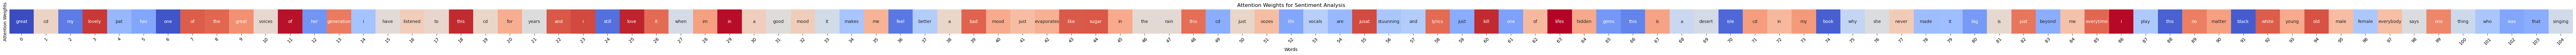

In [45]:

review_text=low_test_text[0]
# Assuming 'attention_weights' contains the attention weights for a specific review
attention_weights = get_attention_weights_for_review(review_text)

# Normalize attention weights for visualization
attention_weights = attention_weights / attention_weights.sum()

# Convert review text to a list of words
words = review_text.split()

print(attention_weights)

# Create a heatmap to visualize attention weights
plt.figure(figsize=(len(words), 1))
sns.heatmap(data=attention_weights.reshape(1, -1), annot=[words], fmt='', cmap='coolwarm', cbar=False)
plt.xlabel('Words')
plt.ylabel('Attention Weights')
plt.title('Attention Weights for Sentiment Analysis')
plt.xticks(rotation=45)
plt.yticks([])
plt.savefig('figures/no_name')
plt.show()